# Assignment 1
### Benjamin Tollison
This is my 3rd re-write of the code and it went from not working at all to running for 7 hours to now being able to kill the python kernel in under 30mins on my computer. I kept the computation in the global scope to prevent all the calls/checks that my older versions were doing and slowing down time. I know this makes my code not as 'pretty', but it runs significantly faster.

The way that I set up the mesh is that the number of nodes will always be a perfect square. All the nodes are placed equal distance from each other producing the following mesh. You can tweak the mesh density coefficient ($\rho_{mesh}$) value to increase the number of nodes. It works best if you $\rho_{mesh} < 31$ and odd. I got my first 'python 3.11.2 kernel is dead' error by pushing the density to 31. 

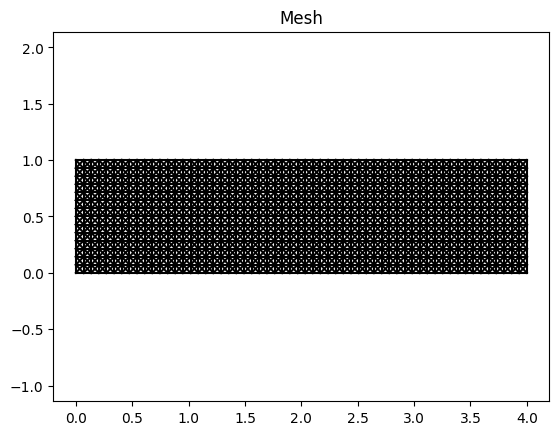

In [1]:
### Benjamin Tollison ### 
from IPython.display import Latex
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np

def PlotSturcture(N,C,color:str):
    m,_ = C.shape
    for i in range(m):
        ii = np.nonzero(C[i])
        plt.plot(N[0,ii][0],N[1,ii][0],color)
        plt.axis('equal')

mesh_density_coefficient = 15 # Change this one variable for a finer mesh
length = 4
height = 1
delta = 1/mesh_density_coefficient
x_step_number,y_step_number = int(length/delta), int(height/delta)
x_cooridinates,y_cooridinates = np.linspace(0,length,x_step_number), np.linspace(0,height,y_step_number)
X,Y = np.meshgrid(x_cooridinates,y_cooridinates)
N = np.vstack((X.ravel(),Y.ravel()))
number_of_nodes = x_step_number*y_step_number
number_of_members = int(6+10*(number_of_nodes**0.5-2)+4*(number_of_nodes**0.5-2)**2)
C = np.zeros((number_of_members,number_of_nodes))
duplicate_check_set = set()
current_duplicate_check_len = len(duplicate_check_set)
member_index_counter = 0
member_lengths = np.zeros(number_of_members) # a special tool that we will use later
for node in range(number_of_nodes-1):
  for other_node in range(1,number_of_nodes):
    if node != other_node:
       node_x1,node_y1 = N[0][node],N[1][node]       
       other_node_x1,other_node_y1 = N[0][other_node],N[1][other_node]
       distance_between_nodes = ((node_x1-other_node_x1)**2+(node_y1-other_node_y1)**2)**0.5
       if distance_between_nodes < delta*2 and member_index_counter < number_of_members:
        connection_check_node_indices = [node,other_node]
        connection_to_check = tuple(1 if i in connection_check_node_indices else 0 for i in range(number_of_nodes))
        duplicate_check_set.add(connection_to_check)
        if len(duplicate_check_set) != current_duplicate_check_len:
          C[member_index_counter][node], C[member_index_counter][other_node] = 1,-1
          member_lengths[member_index_counter] = distance_between_nodes
          member_index_counter += 1
          current_duplicate_check_len = len(duplicate_check_set)
PlotSturcture(N,C,'k')
plt.title('Mesh')
plt.show()

### Now to solve for the 1 norm solution
After solving the 1 norm solution then you apply all the indices that are non-zero and non-negative to then be the only remaining members.

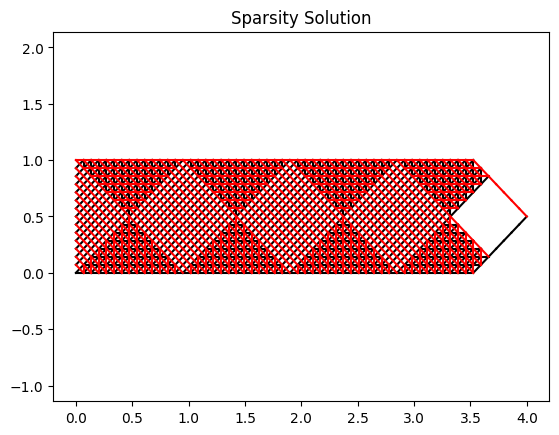

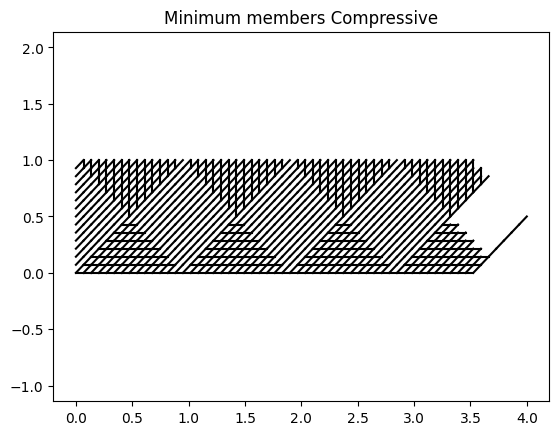

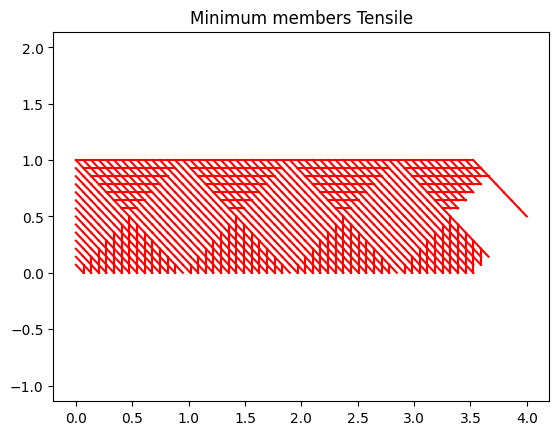

In [2]:
C_B, C_S = C, C
sigma_B = cp.Variable(number_of_members)
sigma_S = cp.Variable(number_of_members)
free_nodes = [i for i in np.where(N[0] != 0.0)]
F_ext = np.zeros((2, number_of_nodes))
R = cp.Variable((2,number_of_nodes))
far_right_nodes = [i for i in map(list,np.where(N[0] == length))]
node_where_F_is_applied = np.argmin(np.abs(N[1][far_right_nodes] - height/2))
P = -1*10**3
F_ext[1][far_right_nodes[0][node_where_F_is_applied]] += P
Cost = cp.norm(sigma_B,1) + cp.norm(sigma_S,1)
Constraints = [N @ C_S.T @ cp.diag(sigma_S) @ C_S - N @ C_B.T @ cp.diag(sigma_B) @ C_B - F_ext - R == 0,
              R[:,free_nodes[0]] == 0,
              sigma_B >= 0,
              sigma_S >= 0]
prob = cp.Problem(cp.Minimize(Cost), Constraints)
prob.solve(solver=cp.ECOS)
sigma_bar_member_indices = np.where(sigma_B.value >= 1*10**-2)[0]
sigma_cable_member_indices = np.where(sigma_S.value >= 1*10**-2)[0]
C_B_final = np.zeros((number_of_members,number_of_nodes))
C_S_final = C_B_final
C_B_final = C_B[sigma_bar_member_indices]
C_S_final = C_S[sigma_cable_member_indices]
PlotSturcture(N,C_B_final,'k')
PlotSturcture(N,C_S_final,'r')
plt.title('Sparsity Solution')
plt.show()
PlotSturcture(N,C_B_final,'k')
plt.title('Minimum members Compressive')
plt.show()
PlotSturcture(N,C_S_final,'r')
plt.title('Minimum members Tensile')
plt.show()

### Mass of the structure
The area from the sparsity solution can be calculated by using the following:
$$A_i = \frac{\sigma L_i}{\sigma_Y}$$
Where $\sigma$ is the respective force mass densities. Doing this for each of the remaining members in the solution by using $ m =\sum \rho A_i L_i$

In [3]:
youngs_modulus_steel = 200*10**9 # Pa
rho_steel = 7850 # kg/m^3
compressive_yield_stress = 500*10**6 #Pa
tensile_yield_stress = 800*10**6 #Pa
b_i = np.linalg.norm(member_lengths,2)
sparity_member_area_compressive = sigma_B.value[sigma_bar_member_indices]@member_lengths[sigma_bar_member_indices] / compressive_yield_stress #(youngs_modulus_steel/member_lengths[sigma_bar_member_indices])
sparity_member_area_tensile = sigma_S.value[sigma_cable_member_indices]@member_lengths[sigma_cable_member_indices] / tensile_yield_stress #(youngs_modulus_steel/member_lengths[sigma_cable_member_indices])
sparity_total_mass = rho_steel*(sparity_member_area_compressive*member_lengths[sigma_bar_member_indices]+sparity_member_area_tensile*member_lengths[sigma_cable_member_indices])
sparsity_total_mass_scalar = np.linalg.norm(sparity_total_mass,1)

### Adding gravity to the sparisty solution
The way that I thought to simulate the mass of the nodes is just to apply a gravitationaly force much smaller than the P force, then to see if the sturcture can support itself. I figured out that if you apply the gravitational force to all the nodes that you get an interesting structure, but it will include all the nodes. The solution does match the current 1 norm solution, but this isn't the exact way that the paper covers.

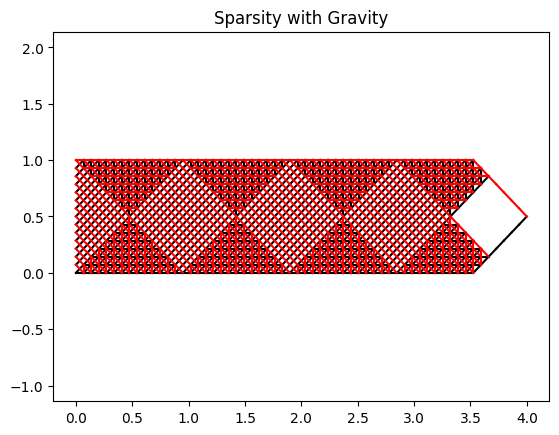

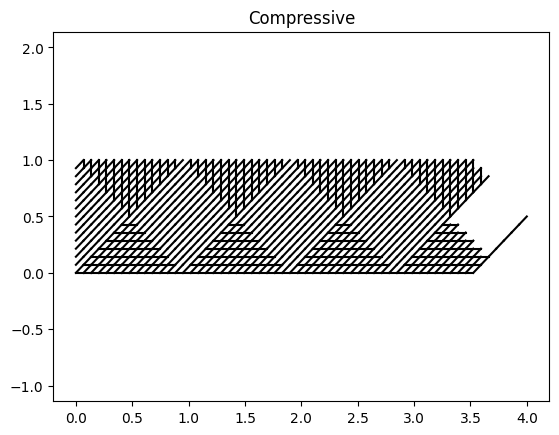

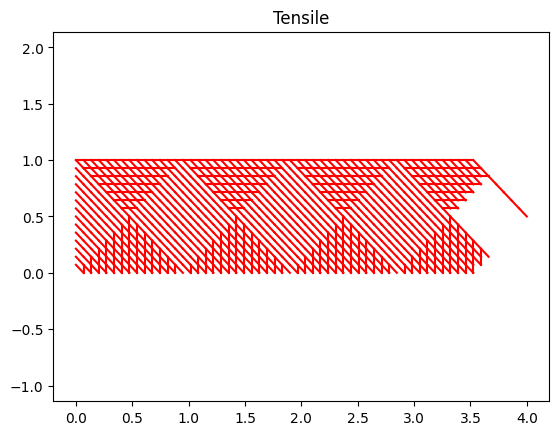

In [4]:
F_ext[1][np.where(np.nonzero(C_B_final))[0]] += -1
F_ext[1][np.where(np.nonzero(C_S_final))[0]] += -1
Cost = cp.norm(sigma_B,1) + cp.norm(sigma_S,1)
Constraints = [N @ C_S.T @ cp.diag(sigma_S) @ C_S - N @ C_B.T @ cp.diag(sigma_B) @ C_B - F_ext - R == 0,
              R[:,free_nodes[0]] == 0,
              sigma_B >= 0,
              sigma_S >= 0]
prob = cp.Problem(cp.Minimize(Cost), Constraints)
prob.solve(solver=cp.ECOS)
C_B_final = np.zeros((number_of_members,number_of_nodes))
C_S_final = C_B_final
C_B_final = C_B[sigma_bar_member_indices]
C_S_final = C_S[sigma_cable_member_indices]
PlotSturcture(N,C_B_final,'k')
PlotSturcture(N,C_S_final,'r')
plt.title('Sparsity with Gravity')
plt.show()
PlotSturcture(N,C_B_final,'k')
plt.title('Compressive')
plt.show()
PlotSturcture(N,C_S_final,'r')
plt.title('Tensile')
plt.show()

### Attempting to follow the paper

I will return the $F_{ext}$ back to only include the P force, and then create 2 more variables for the area and new lengths of the members. 

The new cost function will be dependent on the total mass of the structure.

After messing with the different solvers from the CVXPy library for some time, this was the best solution that I could come up with by following the equations in the paper. This solution looks very different from the norm 1 solution, but the mass calucaltions are after this section.

*Warning: This block of code takes the longest because it uses an iterative method with the SCS solver*

237.5324636


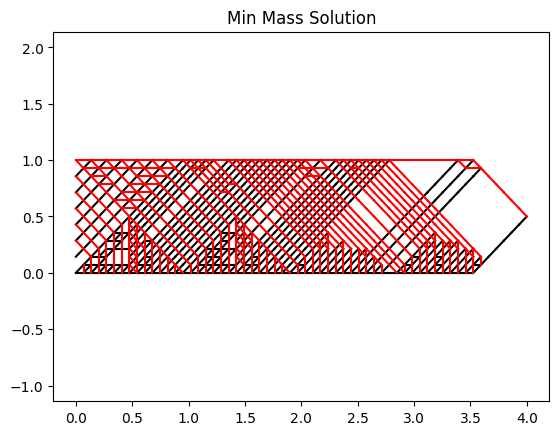

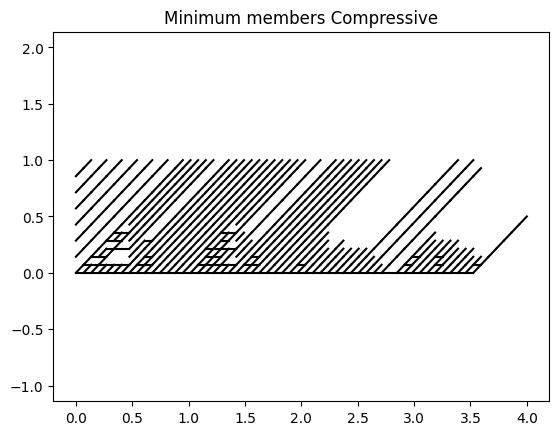

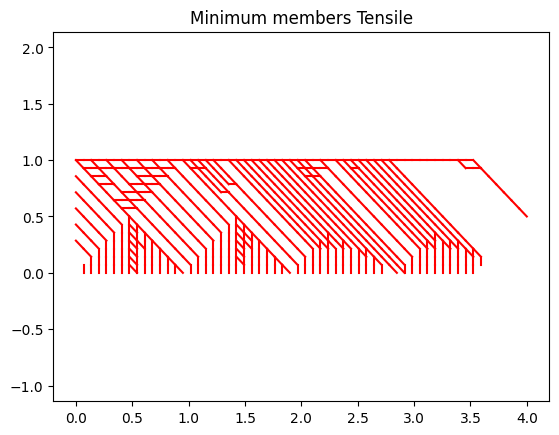

In [5]:
C_B, C_S = C, C
compressive_yield_stress = 500*10**6 #Pa
tensile_yield_stress = 800*10**6 #Pa
shear_yield_stress = 0 # 250*10**6 # Pa
youngs_modulus_steel = 200*10**9 # Pa
rho_steel = 7850 # kg/m^3
b_i = cp.norm(member_lengths,2)
s_i = cp.norm(member_lengths,2)
lambda_B = cp.Variable(number_of_members) 
gamma_S = cp.Variable(number_of_members)
area_S = gamma_S*s_i/tensile_yield_stress
area_B = lambda_B*b_i/compressive_yield_stress
stiffness_B = youngs_modulus_steel*area_B/member_lengths
stiffness_S = youngs_modulus_steel*area_S/member_lengths
tau_B = cp.Variable(1)
c_B = rho_steel*(b_i**2/compressive_yield_stress)
c_S = rho_steel*(s_i**2/tensile_yield_stress)
e_B = -rho_steel*shear_yield_stress*(b_i/compressive_yield_stress)
e_S = -rho_steel*shear_yield_stress*(s_i/tensile_yield_stress)
mass_B = cp.norm(c_B*lambda_B + e_B,1)
mass_S = cp.norm(c_S*gamma_S + e_S,1)
free_nodes = [i for i in np.where(N[0] != 0.0)]
F_ext = np.zeros((2, number_of_nodes))
R = cp.Variable((2,number_of_nodes))
far_right_nodes = [i for i in map(list,np.where(N[0] == length))]
node_where_F_is_applied = np.argmin(np.abs(N[1][far_right_nodes] - height/2))
P = -1*10**3
F_ext[1][far_right_nodes[0][node_where_F_is_applied]] += P
Cost = mass_B + mass_S
Constraints = [N @ C_S.T @ cp.diag(gamma_S) @ C_S - N @ C_B.T @ cp.diag(lambda_B) @ C_B - F_ext - R == 0,
              R[:,free_nodes[0]] == 0,
              lambda_B >= 0,
              gamma_S >= 0,
              tau_B >= 1,
              lambda_B*b_i <= compressive_yield_stress*area_B + tau_B,
              gamma_S*s_i <= tensile_yield_stress*area_S]
prob = cp.Problem(cp.Minimize(Cost), Constraints)
prob.solve(solver=cp.SCS, verbose=False,qcp=True,ignore_dpp=False,max_iters=10**8)
print(prob.solver_stats.solve_time)
lambda_bar_member_indices = np.where(lambda_B.value >= 1*10**-2)[0]
gamma_cable_member_indices = np.where(gamma_S.value >= 1*10**-2)[0]
C_B_final = np.zeros((number_of_members,number_of_nodes))
C_S_final = C_B_final
C_B_final = C_B[lambda_bar_member_indices]
C_S_final = C_S[gamma_cable_member_indices]
PlotSturcture(N,C_B_final,'k')
PlotSturcture(N,C_S_final,'r')
plt.title('Min Mass Solution')
plt.show()
PlotSturcture(N,C_B_final,'k')
plt.title('Minimum members Compressive')
plt.show()
PlotSturcture(N,C_S_final,'r')
plt.title('Minimum members Tensile')
plt.show()

### Now to compare the mass of each structure
The area for maximum stress is expressed in the paper as
$$A_{b_i} = \frac{\lambda_i b_i}{\sigma_Y} - \frac{\tau_{b_i}}{\sigma_Y} $$
$$A_{s_i} = \frac{\gamma_i s_i}{\sigma_Y} - \frac{\tau_{s_i}}{\sigma_Y} $$
and we are ignoring the shear stress and only applying axial loads

Where $\lambda$ and $\gamma$ is the respective force mass densities. Doing this for each of the remaining members in the solution by using $ m =\sum \rho A_i L_i$

In [6]:
total_mass = mass_B.value + mass_S.value
latex_text = r'$\int_{0}^{1} x^2 \, dx = \frac{1}{3}$'
display(Latex(f'The mass of the sparsity solution is = {round(sparsity_total_mass_scalar,3)} kg'))
display(Latex(f'and the mass of the min mass solution is = {round(total_mass,3)} kg'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### It makes sense that the solution that prevents buckling and snapping of the cables from happening will have to have more mass than the solution that allows for $\infty$ stress

### Just for fun
I just wanted to see what the minimum stress solution looks like, so that if this was a solid homogeneous beam it would give an idea of what the internal stresses are.

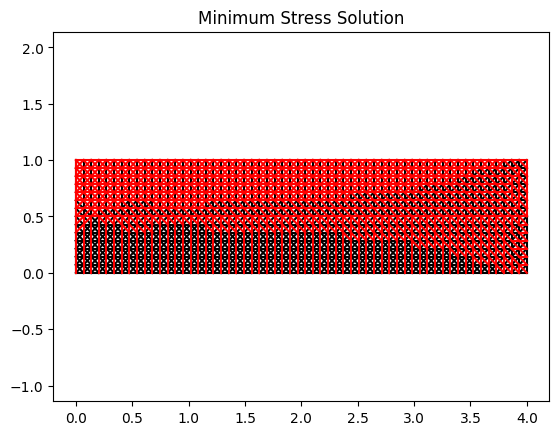

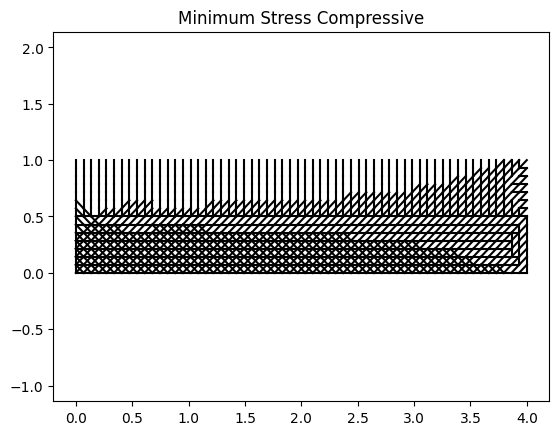

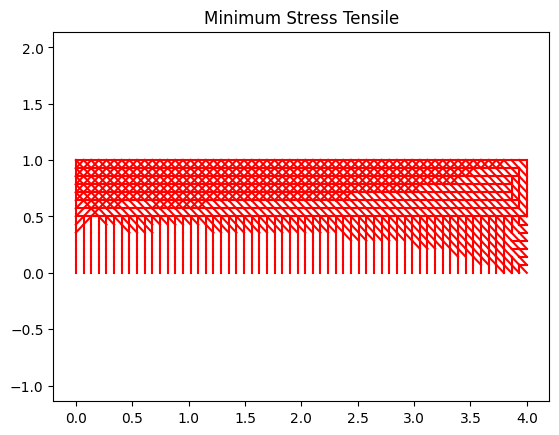

In [7]:
C_B, C_S = C, C
sigma_B = cp.Variable(number_of_members)
sigma_S = cp.Variable(number_of_members)
Cost = cp.norm(sigma_B,2) + cp.norm(sigma_S,2)
Constraints = [N @ C_S.T @ cp.diag(sigma_S) @ C_S - N @ C_B.T @ cp.diag(sigma_B) @ C_B - F_ext - R == 0,
              R[:,free_nodes[0]] == 0,
              sigma_B >= 0,
              sigma_S >= 0]
prob = cp.Problem(cp.Minimize(Cost), Constraints)
prob.solve(solver=cp.ECOS)
sigma_bar_member_indices = np.where(sigma_B.value >= 1*10**-3)[0]
sigma_cable_member_indices = np.where(sigma_S.value >= 1*10**-3)[0]
C_B_final = np.zeros((number_of_members,number_of_nodes))
C_S_final = C_B_final
C_B_final = C_B[sigma_bar_member_indices]
C_S_final = C_S[sigma_cable_member_indices]
PlotSturcture(N,C_B_final,'k')
PlotSturcture(N,C_S_final,'r')
plt.title('Minimum Stress Solution')
plt.show()
PlotSturcture(N,C_B_final,'k')
plt.title('Minimum Stress Compressive')
plt.show()
PlotSturcture(N,C_S_final,'r')
plt.title('Minimum Stress Tensile')
plt.show()